In [56]:
import io
import math
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import seaborn as sns

%matplotlib inline

### Part 0: Setting Up the Data

Loading in our data.

In [49]:
col_data = [("Genre", "|S20"),
            ("Artist", "|S50"),
            ("Track", "|S50"),
            ("Track ID", "|S22"),
            ("Popularity", int),
            ("Acousticness", float),
            ("Danceability", float),
            ("Duration (MS)", int),
            ("Energy", float),
            ("Instrumentalness", float),
            ("Key", "|S2"),
            ("Liveness", float),
            ("Loudness", float),
            ("Mode", int),
            ("Speechiness", float),
            ("Tempo", float),
            ("Time Signature", "|S3"),
            ("Valence", float)]

# based on data set. Mapped before processing to allow for proper steps
# 7 notes (ABCDEFG) - 1/7 step between each. 1/14 for sharp notes
key_mappings = {
    "A": 0,
    "A#": 1/14,
    "B": 1/7,
    "C": 2/7,
    "C#": 5/14,
    "D": 3/7,
    "D#": 7/14,
    "E": 4/7,
    "F": 5/7,
    "F#": 11/14,
    "G": 6/7,
    "G#": 13/14
}

with io.open("SpotifyFeatures.csv", "r", encoding="utf-8") as f:
    data = np.genfromtxt(f, delimiter=",", skip_header=1, comments=None, dtype=col_data)

x array - 132096 x 10   
acousticness 5  
danceability 6    
energy 8  
instrumentalness 9   
key 10  
liveness 11  
mode 13  
speechiness 14  
tempo 15 (normalized to be between 0 and 1)   
valence 17  

should we also include key, time signature? (will need to map to numbers)  

y array - 132096 x 1  
genres (the true labels) mapped to numbers

In [160]:
x = np.empty((data.shape[0], 10))
y = np.empty((data.shape[0], 1))
genre_mapping_dict = {}
genre_idx = 0

for i in range(len(data)):
    row = data[i]
    genre = row[0].decode("utf-8")
    if not genre in genre_mapping_dict:
        genre_mapping_dict[genre] = genre_idx
        genre_idx += 1
    y[i] = genre_mapping_dict[genre]
    
    decoded_key = row[10].decode("utf-8")
    if decoded_key in key_mappings:
        key = key_mappings[decoded_key]
    else:
        key = 1
        
    values = [row[5], row[6], row[8], 
              row[9], key, row[11], row[13], 
              row[14], row[15], row[17]]
    x[i, :] = values

# normalize tempo column
max_tempo = np.max(x[:, 8])
min_tempo = np.min(x[:, 8])
x[:, 8] = (x[:, 8] - min_tempo) / (max_tempo - min_tempo)

### Part 1: Supervised Learning  

Can we predict the genre of a song based on its characteristics?

https://towardsdatascience.com/music-genre-prediction-with-spotifys-audio-features-8a2c81f1a22e

In [161]:
# split X and Y into training and test 
TEST_PERCENTAGE = 10

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = TEST_PERCENTAGE / 100)

In [189]:
# linear regression
from sklearn.linear_model import LinearRegression
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(x_train, y_train)  # perform linear regression
y_pred = np.round(linear_regressor.predict(x_test))  # make predictions
score = linear_regressor.score(x_test, y_test)
print("Test Score: " + str(score))

Test Score: 0.08745504294377993


In [190]:
# logistic regression
logit = LogisticRegression(C = 0.95, solver="lbfgs", multi_class="auto", max_iter=500)
fit = logit.fit(x_train, np.ravel(y_train))
#score returns mean accuracy
print("Test Score: " + str(logit.score(x_test, y_test)))

Test Score: 0.31196063588190764


### Part 2: Unsupervised Learning

What features are most important when defining/classifying genres? Can we use this to create our own genre clusters?

In [35]:
# https://medium.com/latinxinai/discovering-descriptive-music-genres-using-k-means-clustering-d19bdea5e443

# DON'T RUN THIS CELL UNLESS YOU NEED TO, IT TAKES A LONG TIME TO RUN

loss = []
max_centers = 20
for i in range(1, max_centers + 1):
    kmeans = KMeans(n_clusters=i).fit(x)
    loss.append(kmeans.inertia_)

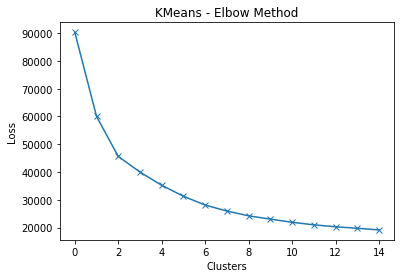

In [36]:
plt.plot(loss, "x-")
plt.title("KMeans - Elbow Method")
plt.xlabel("Clusters")
plt.ylabel("Loss")
plt.show()

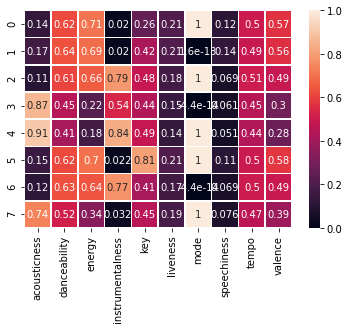

In [182]:
num_points = x.shape[0]
mod_x = x[:num_points, :]
mod_y = y[:num_points]

# looks like the optimal number of clusters is ~8-9
kmeans_optimal = KMeans(n_clusters=8).fit(mod_x)
xlabels = ["acousticness", "danceability", "energy", "instrumentalness", "key", "liveness", "mode", "speechiness", "tempo", "valence"]
ax = sns.heatmap(kmeans_optimal.cluster_centers_, linewidth=0.6, xticklabels=xlabels, annot=True)
plt.show()

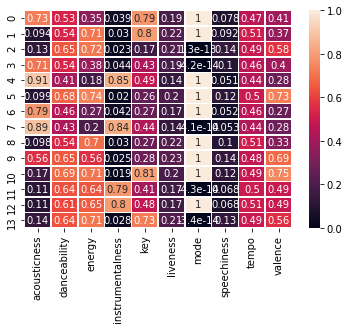

In [183]:
kmeans_predefined = KMeans(n_clusters=14).fit(mod_x)
ax = sns.heatmap(kmeans_predefined.cluster_centers_, linewidth=0.6, xticklabels=xlabels, annot=True)
plt.show()

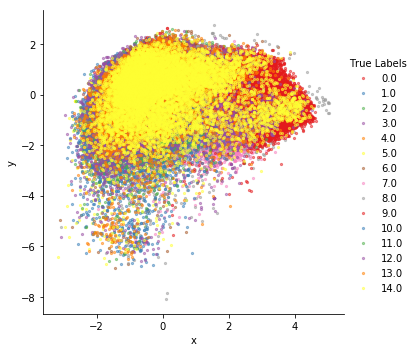

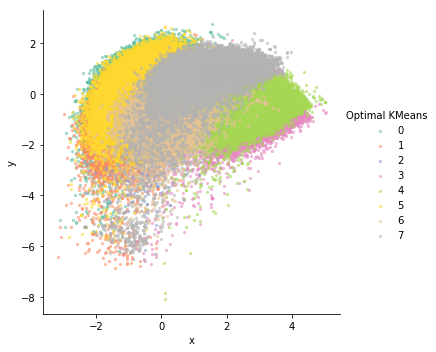

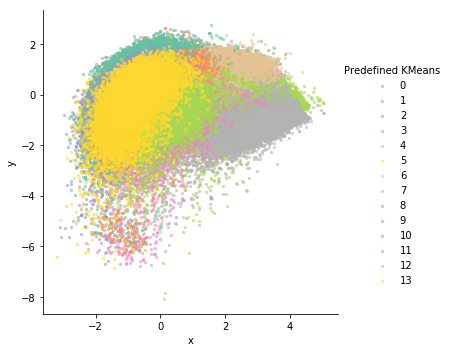

In [185]:
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
df = pd.DataFrame(data=mod_x,
                  index=np.arange(0, mod_x.shape[0]),
                  columns=["acousticness", "danceability", "energy", "instrumentalness", "key", "liveness", "mode", "speechiness", "tempo", "valence"])

#pca = PCA(n_components=2)
#reduced_x = pca.fit_transform(x)

lda = LDA(n_components=2)
reduced_x = lda.fit_transform(mod_x, np.ravel(mod_y))
df["x"] = reduced_x[:, 0]
df["y"] = reduced_x[:, 1]
df["Optimal KMeans"] = kmeans_optimal.labels_
df["Predefined KMeans"] = kmeans_predefined.labels_
df["True Labels"] = mod_y

sns.lmplot(data=df, x="x", y="y", hue="True Labels", fit_reg=False, palette='Set1',
           scatter_kws={'alpha':0.5, 's':5})

sns.lmplot(data=df, x="x", y="y", hue="Optimal KMeans", fit_reg=False, palette='Set2',
           scatter_kws={'alpha':0.5, 's':5})

sns.lmplot(data=df, x="x", y="y", hue="Predefined KMeans", fit_reg=False, palette='Set2',
           scatter_kws={'alpha':0.5, 's':5})